# Analyzing Appliances Energy Prediction Data Set from UCI

## Matthew Sullivan

### EE 498 and Lockheed Martin

As part of my capstone, I am analyzing PHM datasets. I choose UCI's Applicance energy prediction data set. From their website:



> The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).


MAKE LOOK LIKE THIS
https://www.google.com/search?q=blog+post+template&tbm=isch&rlz=1C1GCEA_enUS900US901&hl=en&sa=X&ved=2ahUKEwjnv7rnr_zvAhUSRawKHXUHDx8QrNwCKAB6BQgBEKQC&biw=1903&bih=937#imgrc=KT5h1I3hyF0MVM



In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns
import sklearn

---
# Downloading Data


In [12]:
## REPLACE WITH PYTHON CLIENT EVENTUALLY

import requests

def save_file(url, file_name):
  r = requests.get(url)
  with open(file_name, 'wb') as f:
    f.write(r.content)

save_file('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv',
          'energy_data.csv')

---
# First Model

In [41]:
from sklearn import preprocessing

data = pd.read_csv('energy_data.csv')
dataColumns = []
for name in data:
  dataColumns.append(name)
features = dataColumns.copy()
features.remove('date')
features.remove('Appliances')

# Mean Normalization
meanNormData = data.copy()
meanNormData = data.drop(['date'], axis=1)
meanNormData = (meanNormData - meanNormData.mean()) / meanNormData.std()

# Min-Max Normalization
MinMaxNorm = data.copy()
MinMaxNorm = MinMaxNorm.drop(['date'], axis=1)
MinMaxNorm = (MinMaxNorm - MinMaxNorm.min()) / (MinMaxNorm.max() - MinMaxNorm.min())

Standard Error:  0.019117543021155804
MinMax Error:  0.8519818461945436


Text(0.5, 1.0, 'MinMax Residuals')

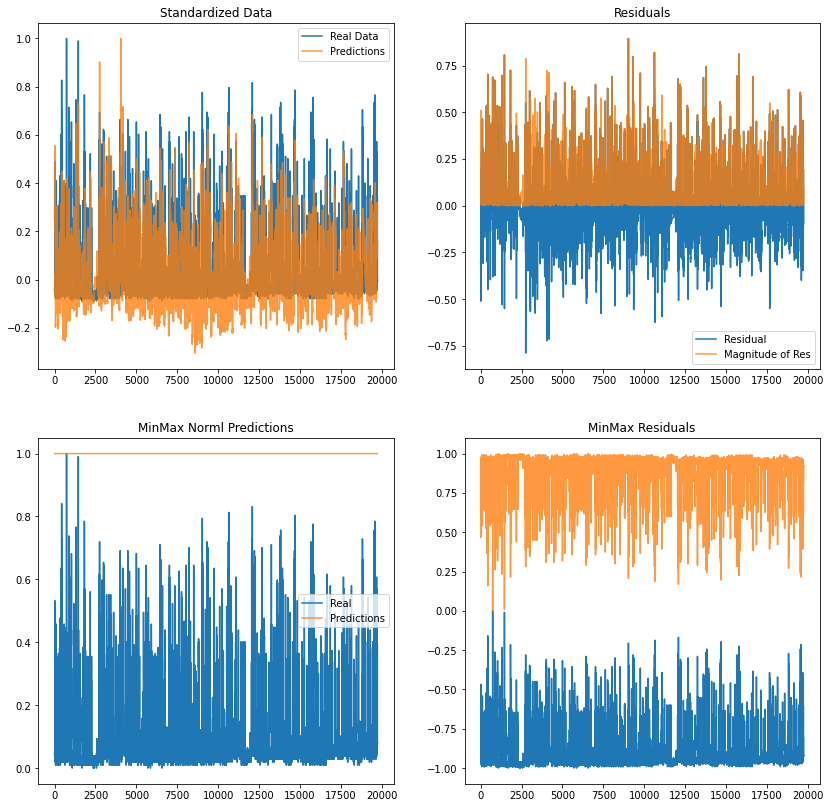

In [51]:
from sklearn import linear_model
from sklearn import metrics

# Training the Mean Normalized Data
modelLASSO = linear_model.Lasso(alpha=0.01)
modelLASSO.fit(meanNormData[features], meanNormData['Appliances'])
ypred = modelLASSO.predict(meanNormData[features])

standardData = meanNormData['Appliances'] / max(meanNormData['Appliances'])
standardPred = ypred / max(ypred)

# Training the MinMax Data
newLasso = linear_model.Lasso(alpha=0.01)
newLasso.fit(MinMaxNorm[features], MinMaxNorm['Appliances'])
MinMaxPred = newLasso.predict(MinMaxNorm[features])
MinMaxData = MinMaxNorm['Appliances']

# # Normalize for Percentage
MinMaxData = MinMaxNorm['Appliances'] / max(MinMaxNorm['Appliances'])
MinMaxPred = MinMaxPred / max(MinMaxPred)

# Error -----------------------------------------------------------------------
standardError = sklearn.metrics.mean_squared_error(standardData, standardPred)
minmaxError   = sklearn.metrics.mean_squared_error(MinMaxData, MinMaxPred)
print("Standard Error: ", standardError)
print("MinMax Error: ", minmaxError)
# Makes sense. Seasonality stuff makes MinMax off

# Plotting ---------------------------------------------------------------------
plt.figure(figsize=(14, 14))
plt.subplot(2,2,1)
plt.plot(standardData)
plt.plot(standardPred, alpha=0.8)
plt.title("Standardized Data")
plt.legend(['Real Data', 'Predictions'])

plt.subplot(2,2,2)
plt.plot(standardData - standardPred)
plt.plot(abs(standardData - standardPred), alpha=0.8)
plt.title('Residuals')
plt.legend(['Residual', 'Magnitude of Res'])

plt.subplot(2,2,3)
plt.plot(MinMaxData)
plt.plot(MinMaxPred, alpha=0.8)
plt.title('MinMax Norml Predictions')
plt.legend(['Real', 'Predictions'])

plt.subplot(2,2,4)
plt.plot(MinMaxData - MinMaxPred)
plt.plot(abs(MinMaxData - MinMaxPred), alpha=0.8)
plt.title('MinMax Residuals')

### Analysis
From previous exploration, mean normalizing improve the model. I assume this is the case as the weather is not too volatile in California. 

Looks good enough to me, however, this is predicting training data. Can we reproduce results with a test data set? 

In [53]:
# Splitting Data
from sklearn.model_selection import train_test_split

featureData = meanNormData[features]
labelData = meanNormData['Appliances']

train_features, test_features, train_labels, test_labels = train_test_split(featureData, labelData, test_size=0.33)

In [54]:
from sklearn import linear_model
from sklearn import metrics

lassoModel = linear_model.Lasso(alpha=0.01)
lassoModel.fit(train_features, train_labels)

predictions = lassoModel.predict(test_features)

standardLabels = test_labels / max(test_labels)
standardPred   = predictions / max(predictions)

standardError = sklearn.metrics.mean_squared_error(standardLabels, standardPred)
print("Standard Error: ", standardError) # not great. 

Standard Error:  0.02092424973882732


### Analysis
Looks like it won't be that simple lol. Mean normalization improved the model by < 0.01 

---
# Data Exploration

In [9]:
all_dates_string = data['date']
all_dates = []

for date_string in all_dates_string:
    all_dates.append( datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S") )

plotting_dates = matplotlib.dates.date2num(all_dates)

In [10]:
# ------------------------
#        DAILY
# ------------------------
#  STOPS AT 20,000
counter = 1
dateKeys = []
date_map = {}
for date in all_dates:
    day = str(date.day)
    if int(str(date.day)) < 10:
        day = "0" + str(date.day)
    currString = str(date.year) + "-0" + str(date.month) + "-" + day
    if currString not in date_map:
        currDF = data.loc[data['date'].str.contains(currString, case=False)]
        date_map[currString] = currDF
        dateKeys.append(currString)
        counter = counter + 1
    if (counter % 1000 == 0):
        print('Count at: ', counter)

97.6949581960983


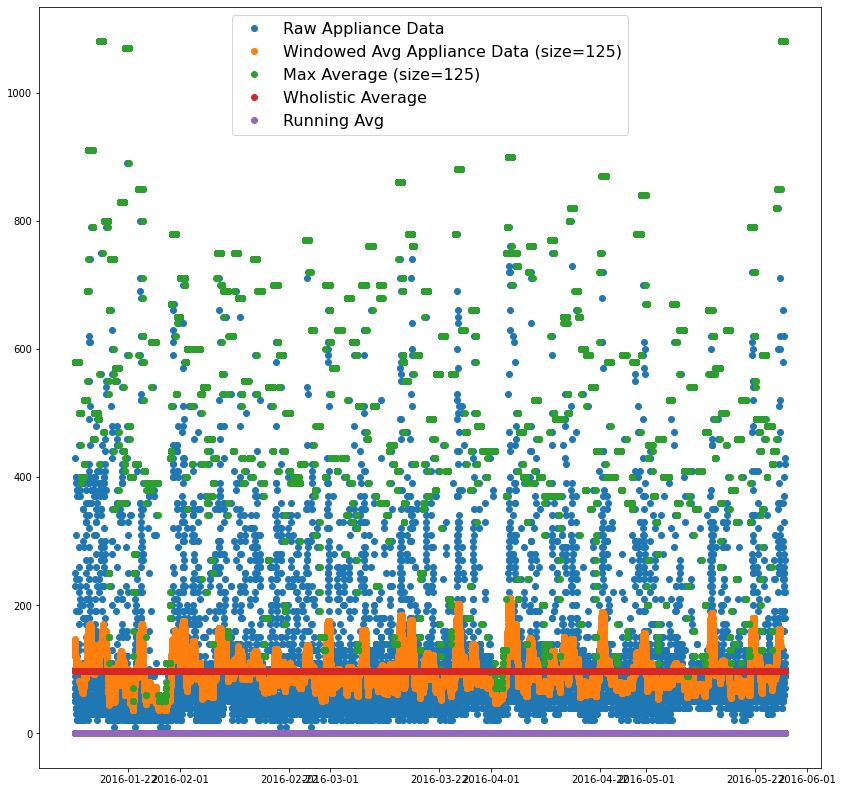

In [11]:
appliance_data = data['Appliances'].to_numpy()
#20,000 samples, average every 100
avg_app_data = np.zeros(len(appliance_data))
averging_size = 125
max_average = np.zeros(len(appliance_data))
running_avg = np.zeros(len(appliance_data))
for i in range(0, len(appliance_data)):
    if (i < averging_size):
        temp = appliance_data[0:i+50]
    elif (i > (len(appliance_data) - averging_size)):
        temp = appliance_data[-(i+averging_size):]
    else:
        half = int(averging_size/2)
        temp = appliance_data[i-half:i+half]
    
    max_average[i] = max(temp)
    temp = sum(temp) / len(temp)
    avg_app_data[i] = temp

n = len(appliance_data)
applianceFFT = np.fft.fft(appliance_data)
w = [(2*np.pi)/(np.pi*n)*i for i in range(0, n)]
FFTfreq = np.fft.fftfreq(n)

average_value = np.mean(appliance_data)
print(average_value)

plt.figure(figsize=(14,14))
plt.plot_date(plotting_dates, appliance_data)
plt.plot_date(plotting_dates, avg_app_data)
plt.plot_date(plotting_dates, max_average)
plt.plot_date(plotting_dates, np.ones(len(appliance_data))*average_value)
plt.plot_date(plotting_dates, running_avg)
plt.legend(['Raw Appliance Data', 'Windowed Avg Appliance Data (size=125)', 'Max Average (size=125)', 'Wholistic Average', 'Running Avg'], fontsize=16)

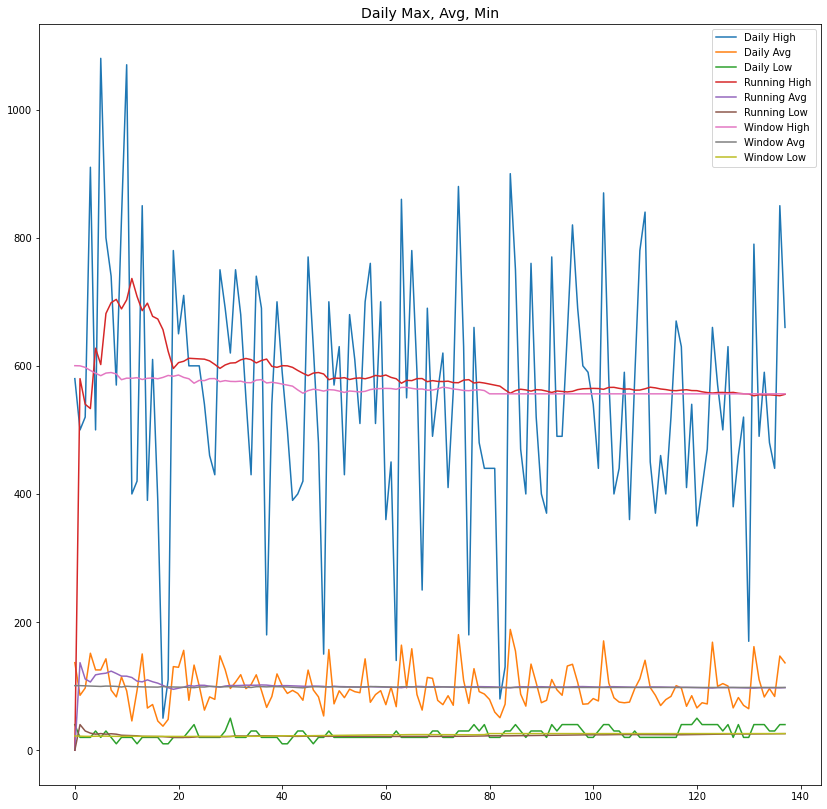

In [12]:
index = 0
numKeys = len(dateKeys)
daily_high = np.zeros(numKeys)
daily_avg = np.zeros(numKeys)
daily_low = np.zeros(numKeys)

for d in dateKeys:
    currDay = date_map[d]
    currAppliance = currDay['Appliances'].to_numpy()
    daily_high[index] = max(currAppliance)
    daily_avg[index] = np.mean(currAppliance)
    daily_low[index] = min(currAppliance)
    index = index + 1
# Running averages
running_high = np.zeros(numKeys)
running_avg = np.zeros(numKeys)
running_low = np.zeros(numKeys)
for i in range(1, numKeys):
    running_high[i] = np.convolve(daily_high[0:i], np.ones(i)/i, mode='valid')
    running_avg[i] = np.convolve(daily_avg[0:i], np.ones(i)/i, mode='valid')
    running_low[i] = np.convolve(daily_low[0:i], np.ones(i)/i, mode='valid')

# Windowed
window_size = 80
window_high = np.zeros(numKeys)
window_avg = np.zeros(numKeys)
window_low = np.zeros(numKeys)
for i in range(0, numKeys):
    half = int(window_size/2)
    if (i < window_size):
        temp_high = daily_high[0:i+half]
        temp_avg = daily_avg[0:i+half]
        temp_low = daily_low[0:i+half]
    elif (i > (len(daily_high) - window_size)):
        temp_high = daily_high[-(i+window_size):]
        temp_avg = daily_avg[-(i+window_size):]
        temp_low = daily_low[-(i+window_size):]
    else:
        temp_high = daily_high[i-half:i+half]
        temp_avg = daily_avg[i-half:i+half]
        temp_low = daily_low[i-half:i+half]
    window_high[i] = sum(temp_high) / len(temp_high)
    window_avg[i] = sum(temp_avg) / len(temp_avg)
    window_low[i] = sum(temp_low) / len(temp_low)

plt.figure(figsize=(14,14))
plt.plot(daily_high)
plt.plot(daily_avg)
plt.plot(daily_low)

plt.plot(running_high)
plt.plot(running_avg)
plt.plot(running_low)

plt.plot(window_high)
plt.plot(window_avg)
plt.plot(window_low)

plt.title('Daily Max, Avg, Min', fontsize=14)
plt.legend(['Daily High', 'Daily Avg', 'Daily Low','Running High', 'Running Avg', 'Running Low', 'Window High', 'Window Avg', 'Window Low'])

Plot the residuals and see how non-random the residuals are. Can help explain things a bit better. 

Plot residuals and look for patterns. Want it to be normal but often not. 

Can also generate features. Features (A, B, C) and ouput Z. Then we say, how does A and B map to output Z (read research.). Is it linear? Is it ---. We could 